In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
import seaborn as sns
from wordcloud import WordCloud


In [2]:
games_df = pd.read_csv('games.csv')
player_play_df = pd.read_csv('player_play.csv')
players_df = pd.read_csv('players.csv')
plays_df = pd.read_csv('plays.csv')
tracking_df = pd.read_csv('tracking_week_1.csv')

In [3]:
for name, df in [('Games', games_df), ('Player Play', player_play_df), 
                 ('Players', players_df), ('Plays', plays_df), 
                 ('Tracking', tracking_df)]:
    print(f"\n{name} DataFrame:")
    print(df.info())
    print("\nFirst few rows:")
    print(df.head())


Games DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gameId             136 non-null    int64 
 1   season             136 non-null    int64 
 2   week               136 non-null    int64 
 3   gameDate           136 non-null    object
 4   gameTimeEastern    136 non-null    object
 5   homeTeamAbbr       136 non-null    object
 6   visitorTeamAbbr    136 non-null    object
 7   homeFinalScore     136 non-null    int64 
 8   visitorFinalScore  136 non-null    int64 
dtypes: int64(5), object(4)
memory usage: 9.7+ KB
None

First few rows:
       gameId  season  week   gameDate gameTimeEastern homeTeamAbbr  \
0  2022090800    2022     1   9/8/2022        20:20:00           LA   
1  2022091100    2022     1  9/11/2022        13:00:00          ATL   
2  2022091101    2022     1  9/11/2022        13:00:00          CAR   
3  20

### Initial Exploratory Analysis

In [4]:
## game outcomes
game_outcomes = games_df['homeFinalScore'] > games_df['visitorFinalScore']
home_wins = game_outcomes.sum()
total_games = len(game_outcomes)
print(f"\nHome team win percentage: {home_wins/total_games:.2%}")


Home team win percentage: 53.68%


In [42]:
# Function to categorize play types based on play description
def categorize_play_type(row):
    description = row['playDescription'].lower()
    
    # Check for specific play types first
    if row['passResult'] == 'C':
        return 'Completed Pass'
    elif row['passResult'] == 'I':
        return 'Incomplete Pass'
    elif 'sack' in description:
        return 'Sack'
    elif 'interception' in description or 'intercepted' in description:
        return 'Interception'
    elif row['qbKneel'] == 1:
        return 'QB Kneel'
    elif row['qbSpike'] == 1:
        return 'QB Spike'
    elif 'fumble' in description:
        return 'Fumble'
    elif 'penalty' in description:
        return 'Penalty'
    elif 'touchdown' in description:
        return 'Touchdown'
    elif 'field goal' in description:
        return 'Field Goal'
    elif 'punt' in description:
        return 'Punt'
    elif 'kickoff' in description:
        return 'Kickoff'
    
    # Check for run plays
    if pd.notna(row['rushLocationType']):
        return f"Run - {row['rushLocationType'].replace('_', ' ').title()}"
    
    # Check for pass plays not caught by earlier conditions
    if pd.notna(row['passResult']):
        return 'Other Pass Play'
    
    # If none of the above, categorize as Other
    return 'Other'

In [43]:
# Apply the categorization function
plays_df['playType'] = plays_df.apply(categorize_play_type, axis=1)

# Analyze play types
play_type_counts = plays_df['playType'].value_counts()
print("Play type distribution:")
print(play_type_counts)

# Calculate percentage of each play type
play_type_percentages = (play_type_counts / len(plays_df)) * 100
print("\nPercentage of each play type:")
for play_type, percentage in play_type_percentages.items():
    print(f"{play_type}: {percentage:.2f}%")

Play type distribution:
playType
Completed Pass         5624
Incomplete Pass        2911
Run - Inside Right     1832
Run - Inside Left      1798
Run - Outside Right    1349
Run - Outside Left     1185
Sack                    608
Touchdown               225
Interception            193
QB Kneel                165
Penalty                 133
Fumble                  101
Name: count, dtype: int64

Percentage of each play type:
Completed Pass: 34.88%
Incomplete Pass: 18.05%
Run - Inside Right: 11.36%
Run - Inside Left: 11.15%
Run - Outside Right: 8.37%
Run - Outside Left: 7.35%
Sack: 3.77%
Touchdown: 1.40%
Interception: 1.20%
QB Kneel: 1.02%
Penalty: 0.82%
Fumble: 0.63%


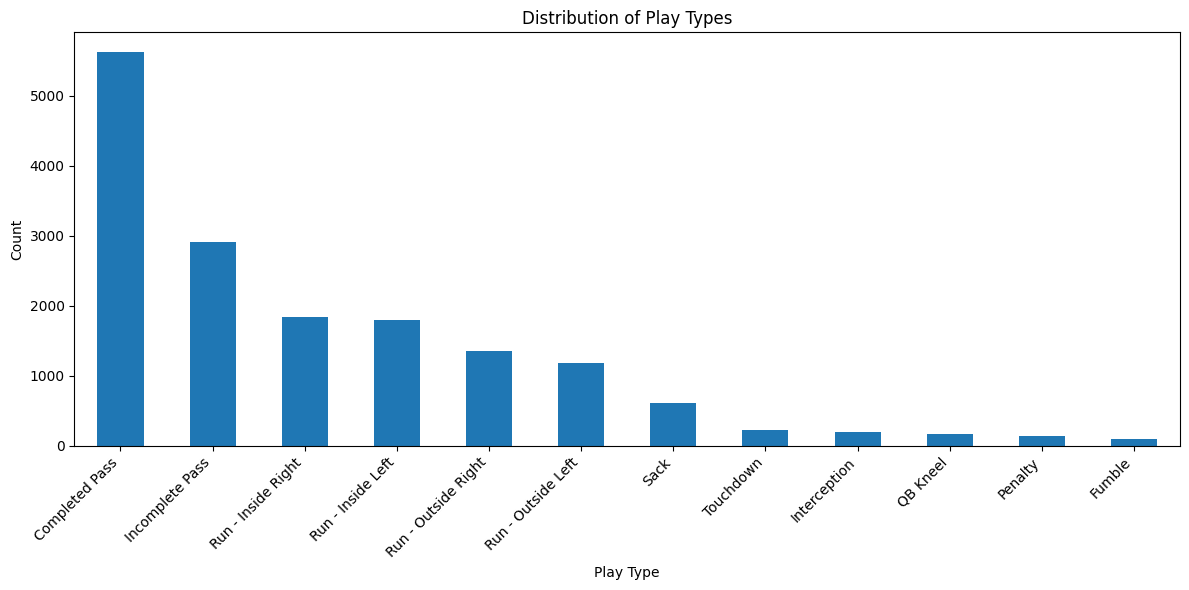

In [44]:
# Visualize the play type distribution
plt.figure(figsize=(12, 6))
play_type_counts.plot(kind='bar')
plt.title('Distribution of Play Types')
plt.xlabel('Play Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Average yards gained by play type:
playType
Completed Pass         10.991643
Fumble                 -0.554455
Incomplete Pass        -0.091034
Interception            0.000000
Penalty                 7.533835
QB Kneel               -1.042424
Run - Inside Left       4.749166
Run - Inside Right      4.816594
Run - Outside Left      4.239662
Run - Outside Right     4.037064
Sack                   -6.957237
Touchdown               9.413333
Name: yardsGained, dtype: float64


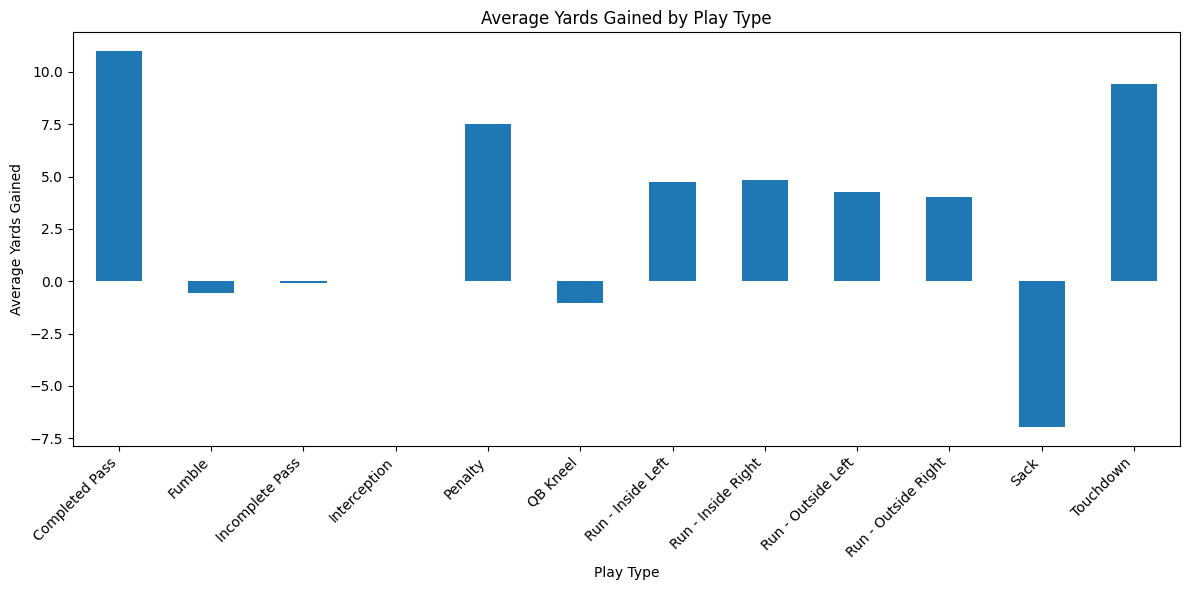

In [16]:
# calculate the average number of yards gained for each play type
average_yards_gained = plays_df.groupby('playType')['yardsGained'].mean()
print("\nAverage yards gained by play type:")
print(average_yards_gained)

# Visualize the average yards gained by play type
plt.figure(figsize=(12, 6))
average_yards_gained.plot(kind='bar')
plt.title('Average Yards Gained by Play Type')
plt.xlabel('Play Type')
plt.ylabel('Average Yards Gained')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [17]:
# calculate total number of plays in plays_df
total_plays = len(plays_df)

# print the total number of plays
print(f"\nTotal number of plays: {total_plays}")


Total number of plays: 16124


In [19]:
# calculate average number of plays per game
average_plays_per_game = total_plays / total_games
print(f"Average number of plays per game: {average_plays_per_game:.2f}")

#calculate median number of plays per game
median_plays_per_game = plays_df.groupby('gameId')['playId'].count().median()
print(f"Median number of plays per game: {median_plays_per_game}")

Average number of plays per game: 118.56
Median number of plays per game: 118.0


In [28]:
# Check unique game IDs for LA
la_games = plays_df[plays_df['possessionTeam'] == 'LA']['gameId'].unique()
print(f"Number of unique game IDs for LA: {len(la_games)}")

# Distribution of plays per game for LA
la_plays_per_game = plays_df[plays_df['possessionTeam'] == 'LA'].groupby('gameId').size()
print("\nDistribution of plays per game for LA:")
print(la_plays_per_game)

# Check the dates of LA's games
la_game_dates = plays_df[plays_df['possessionTeam'] == 'LA']['gameId'].unique()
print("\nDates of LA's games:")
for game_id in la_game_dates:
    print(f"Game ID: {game_id}, Date: {str(game_id)[:8]}")

Number of unique game IDs for LA: 8

Distribution of plays per game for LA:
gameId
2022090800    64
2022091807    61
2022092510    45
2022100300    65
2022100912    61
2022101608    63
2022103010    56
2022110609    51
dtype: int64

Dates of LA's games:
Game ID: 2022101608, Date: 20221016
Game ID: 2022092510, Date: 20220925
Game ID: 2022100912, Date: 20221009
Game ID: 2022090800, Date: 20220908
Game ID: 2022091807, Date: 20220918
Game ID: 2022100300, Date: 20221003
Game ID: 2022110609, Date: 20221106
Game ID: 2022103010, Date: 20221030


In [26]:
# Total plays for each team
team_plays = plays_df['possessionTeam'].value_counts().reset_index()
team_plays.columns = ['team', 'total_plays']

In [29]:
# find total number of games for each team
team_games = games_df['homeTeamAbbr'].value_counts().add(games_df['visitorTeamAbbr'].value_counts(), fill_value=0).reset_index()
team_games.columns = ['team', 'games']
print("\nTotal number of games for each team:")
print(team_games)



Total number of games for each team:
   team  games
0   ARI      9
1   ATL      9
2   BAL      9
3   BUF      8
4   CAR      9
5   CHI      9
6   CIN      9
7   CLE      8
8   DAL      8
9   DEN      8
10  DET      8
11   GB      9
12  HOU      8
13  IND      9
14  JAX      9
15   KC      8
16   LA      8
17  LAC      8
18   LV      8
19  MIA      9
20  MIN      8
21   NE      9
22   NO      9
23  NYG      8
24  NYJ      9
25  PHI      8
26  PIT      8
27  SEA      9
28   SF      8
29   TB      9
30  TEN      8
31  WAS      9


In [37]:
# make a table with three columns: one with team name, one with total games, and one with toal plays
team_summary = pd.merge(team_games, team_plays, on='team')
# make team_summary be in decending order of total plays
team_summary = team_summary.sort_values('total_plays', ascending=False)

print("\nTeam summary:")
print(team_summary)



Team summary:
   team  games  total_plays
13  IND      9          576
0   ARI      9          569
31  WAS      9          568
29   TB      9          561
6   CIN      9          551
22   NO      9          551
11   GB      9          550
24  NYJ      9          544
14  JAX      9          543
21   NE      9          528
15   KC      8          527
19  MIA      9          517
2   BAL      9          517
7   CLE      8          512
1   ATL      9          511
5   CHI      9          510
25  PHI      8          507
17  LAC      8          499
9   DEN      8          490
20  MIN      8          483
10  DET      8          480
26  PIT      8          479
18   LV      8          469
3   BUF      8          469
23  NYG      8          469
16   LA      8          466
27  SEA      9          461
4   CAR      9          458
28   SF      8          454
8   DAL      8          453
12  HOU      8          432
30  TEN      8          420


In [38]:
# calculate average number of plays per game for each team and add it to a new column in team_summary
team_summary['avg_playpg'] = round(team_summary['total_plays'] / team_summary['games'], 2)
print("\nTeam summary with average plays per game:")
print(team_summary)


Team summary with average plays per game:
   team  games  total_plays  avg_playpg
13  IND      9          576       64.00
0   ARI      9          569       63.22
31  WAS      9          568       63.11
29   TB      9          561       62.33
6   CIN      9          551       61.22
22   NO      9          551       61.22
11   GB      9          550       61.11
24  NYJ      9          544       60.44
14  JAX      9          543       60.33
21   NE      9          528       58.67
15   KC      8          527       65.88
19  MIA      9          517       57.44
2   BAL      9          517       57.44
7   CLE      8          512       64.00
1   ATL      9          511       56.78
5   CHI      9          510       56.67
25  PHI      8          507       63.38
17  LAC      8          499       62.38
9   DEN      8          490       61.25
20  MIN      8          483       60.38
10  DET      8          480       60.00
26  PIT      8          479       59.88
18   LV      8          469       58.

In [39]:
# take a sum of the total plays and games to get the league totals
league_totals = team_summary.sum()
print("\nLeague totals:")
print(league_totals)


League totals:
team           INDARIWASTBCINNOGBNYJJAXNEKCMIABALCLEATLCHIPHI...
games                                                        272
total_plays                                                16124
avg_playpg                                               1897.22
dtype: object


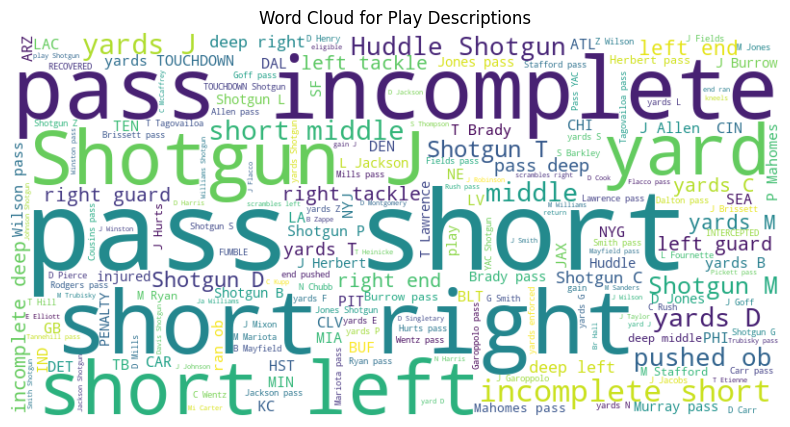

In [47]:
# Combine all play descriptions into a single string
text = ' '.join(plays_df['playDescription'].dropna())

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Play Descriptions')
plt.show()



In [48]:
# use the games_df to calculate the total number of games per team
games_per_team = games_df['homeTeamAbbr'].value_counts().add(games_df['visitorTeamAbbr'].value_counts(), fill_value=0)

# print the total number of games per team
print("\nTotal number of games per team:")
print(games_per_team)


Total number of games per team:
ARI    9
ATL    9
BAL    9
BUF    8
CAR    9
CHI    9
CIN    9
CLE    8
DAL    8
DEN    8
DET    8
GB     9
HOU    8
IND    9
JAX    9
KC     8
LA     8
LAC    8
LV     8
MIA    9
MIN    8
NE     9
NO     9
NYG    8
NYJ    9
PHI    8
PIT    8
SEA    9
SF     8
TB     9
TEN    8
WAS    9
Name: count, dtype: int64


In [63]:
# calculate total number of points scored by each team over all of their games
points_scored = games_df.groupby('homeTeamAbbr')['homeFinalScore'].sum().add(games_df.groupby('visitorTeamAbbr')['visitorFinalScore'].sum(), fill_value=0)

# join the points_scored Series with the games_per_team Series
team_points = pd.concat([games_per_team, points_scored], axis=1)
team_points.columns = ['games', 'points']

# calculate points per game for each team and add it to a new column in team_points
team_points['pts_pg'] = round(team_points['points'] / team_points['games'], 2)
# sort the DataFrame by points in descending order
team_points = team_points.sort_values('points', ascending=False)

# add a new column to team_points that shows how many points each team was scored against
team_points['points_against'] = games_df.groupby('homeTeamAbbr')['visitorFinalScore'].sum().add(games_df.groupby('visitorTeamAbbr')['homeFinalScore'].sum(), fill_value=0)

# add a new column to team_points that shows the average number of points each team was scored against
team_points['pts_against_pg'] = round(team_points['points_against'] / team_points['games'], 2)

# add a new column to team_points that shows the point differential for each team
team_points['point_differential'] = team_points['points'] - team_points['points_against']

# add a new column titled "wins" to team_points that shows how many wins the team had
home_wins = games_df[games_df['homeFinalScore'] > games_df['visitorFinalScore']]['homeTeamAbbr'].value_counts()
visitor_wins = games_df[games_df['visitorFinalScore'] > games_df['homeFinalScore']]['visitorTeamAbbr'].value_counts()
team_points['wins'] = (home_wins.add(visitor_wins, fill_value=0)).astype(int)

# add a new column titled "losses" to team_points that shows how many losses the team had
team_points['losses'] = team_points['games'] - team_points['wins']

print("\nTeam points summary:")
print(team_points)


Team points summary:
     games  points  pts_pg  points_against  pts_against_pg  \
KC       8     243   30.38             189           23.62   
SEA      9     241   26.78             220           24.44   
BAL      9     235   26.11             196           21.78   
CIN      9     228   25.33             185           20.56   
PHI      8     225   28.12             135           16.88   
BUF      8     220   27.50             118           14.75   
ATL      9     217   24.11             225           25.00   
MIA      9     213   23.67             224           24.89   
NO       9     212   23.56             227           25.22   
ARI      9     203   22.56             241           26.78   
NE       9     203   22.56             166           18.44   
CLE      8     200   25.00             199           24.88   
JAX      9     199   22.11             178           19.78   
NYJ      9     196   21.78             176           19.56   
MIN      8     193   24.12             161      

In [60]:
# find the latest date in the games_df
# convert the 'gameDate' column to a datetime object
games_df['gameDate'] = pd.to_datetime(games_df['gameDate'])
latest_date = games_df['gameDate'].max()
print(f"\nLatest date in games_df: {latest_date}")


Latest date in games_df: 2022-11-07 00:00:00


In [64]:
# print the size of player_play_df
print("\nSize of player_play_df:")
print(player_play_df.shape)


Size of player_play_df:
(354727, 50)


In [65]:
# which player has the most entries in player_play_df
most_entries = player_play_df['nflId'].value_counts().idxmax()
print(f"\nPlayer with the most entries in player_play_df: {most_entries}")


Player with the most entries in player_play_df: 46106


In [68]:
# find the number of unique players in player_play_df
unique_players = player_play_df['nflId'].nunique()
print(f"\nNumber of unique players in player_play_df: {unique_players}")

# find the number of unique players in players_df
unique_players = players_df['nflId'].nunique()
print(f"\nNumber of unique players in players_df: {unique_players}")



Number of unique players in player_play_df: 1697

Number of unique players in players_df: 1697


In [69]:
# are there any players in player_play_df that are not in players_df
players_in_play = player_play_df['nflId'].unique()
players_in_players = players_df['nflId'].unique()
players_not_in_players = set(players_in_play) - set(players_in_players)
print("\nPlayers in player_play_df that are not in players_df:")
print(players_not_in_players)


Players in player_play_df that are not in players_df:
set()


In [72]:
# find which players show up the most in player_play_df and get their names from players_df
most_common_players = player_play_df['nflId'].value_counts().head(12)
player_names = players_df[players_df['nflId'].isin(most_common_players.index)]['displayName']
# get their positions and add them to the player_names Series
player_positions = players_df[players_df['nflId'].isin(most_common_players.index)]['position']
player_names = player_names + ' (' + player_positions + ')'

print("\nMost common players in player_play_df:")
print(player_names)



Most common players in player_play_df:
0            Tom Brady (QB)
71       Kelvin Beachum (T)
166        Charles Leno (T)
182      Andrew Norwell (G)
248     Shaquille Mason (G)
568      Quenton Nelson (G)
583     Rashaan Evans (ILB)
597        Braden Smith (T)
769       Kyler Murray (QB)
1007      Tristan Wirfs (T)
1267      Richie Grant (SS)
1314     Robert Hainsey (C)
dtype: object
